# Project 1: Food Vision Big

In [44]:
import tensorflow as tf
import numpy as np

tf.__version__

'2.13.0'

## Check GPU

* Check if the GPU offered by Google Colab is compatible with mixed precision training.
* For mixed precision training our GPU needs a score of 7.0+

In [45]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e20b7460-f336-ab1c-864a-7ac26d910e4c)


## Use Tensorflow datasets to Download data

https://www.tensorflow.org/datasets/overview


In [46]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [47]:
# List all avaiable datasets
datasets_list = tfds.list_builders() # get all avaiable datasets in TFDS
print('food101' in datasets_list)

True


In [48]:
# Load in the data (takes a few minutes)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True, # Shuffle data
                                             as_supervised=True, # data returns as a tuple
                                             with_info=True)

In [49]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [50]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

To become one with the data, we need:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [51]:
# Take one sample of the train data
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [52]:
train_one_sample = train_data.take(1) # samples are in format(image_tensot, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [53]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
        Image shape: {image.shape},
        Image datatype: {image.dtype}
        Target class from Food101 (tensor_form): {label}
        Class name (str_form): {class_names[label.numpy()]}
        """)


        Image shape: (512, 512, 3),
        Image datatype: <dtype: 'uint8'>
        Target class from Food101 (tensor_form): 31
        Class name (str_form): donuts
        


In [54]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

In [55]:
# What are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensoFlow Datasets

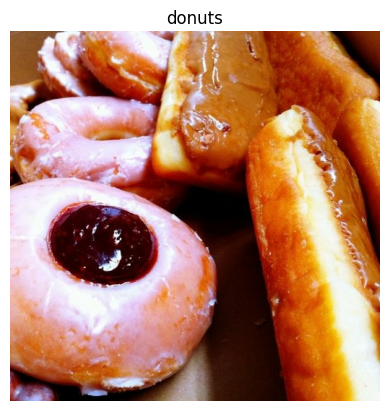

In [56]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Our Data:
* In 'uint8' datatype
* Different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What models like:
* Data in 'float32' dtype (or mixed precision 'float16' & 'float32')
* Same size Batches
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

In [57]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  #image = image/255. # Scale values (Some models don't need it)
  return tf.cast(image, tf.float32), label # Return (float32_image, label) tuple

In [58]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n')
print(f'Image After preprocessing:\n {image[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n')

Image before preprocessing:
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image After preprocessing:
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]..., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

Read: https://www.tensorflow.org/guide/data

In [59]:
from tensorflow.python import train
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test_data (and parallelize)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [60]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

* Create callbacks to help while our model trains:
1. TensorBoard
2. ModelCheckpoint callback

In [61]:
import datetime

# Create a tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.

  Args:
    dir_name: target directory to store TensoBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

In [62]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor="val_acc",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0)

## Setup mixed precision

In [63]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

In [64]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [65]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False) # Make sure layers are not training
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

## Checking layer dtype policies (are we using mixed precision)

In [67]:
from tensorflow.python.ops.gen_logging_ops import Print
# check the dtype_policy attributes
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fit the feature extraction mode

To do list:
1. Build a feature extraction model
2. Fine-tune some of the frozen layers

In [68]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                                            experiment_name='efficientb0_101_food_classes'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_food_classes/20230915-144441
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7186 - accuracy: 0.5805

2368/2368 [==============================] - 211s 80ms/step - loss: 1.7186 - accuracy: 0.5805 - val_loss: 1.1165 - val_accuracy: 0.7044
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2002 - accuracy: 0.6892

2368/2368 [==============================] - 197s 81ms/step - loss: 1.2002 - accuracy: 0.6892 - val_loss: 1.0270 - val_accuracy: 0.7161
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.7245

2368/2368 [==============================] - 187s 77ms/step - loss: 1.0542 - accuracy: 0.7245 - val_loss: 0.9886 - val_accuracy: 0.7254


In [69]:
# Evaluate on the whole dataset
model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.0011 - accuracy: 0.7266


[1.0011024475097656, 0.7266138792037964]

### Fine-Tunning

To beat 77.4%

In [70]:
# Download Zero-To-Mastery to fine tunning
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2023-09-15 14:55:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2023-09-15 14:55:42 (152 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’ saved [16976857/16976857]



In [71]:
# Unzip the model
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

mkdir: cannot create directory ‘downloaded_gs_model’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  


In [72]:
ztm_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")
ztm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [73]:
ztm_model.evaluate(test_data)

790/790 [==============================] - 56s 68ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0880998373031616, 0.7066138386726379]

In [74]:
# Set all of layers trainable
ztm_model.trainable = True

In [75]:
# Check the dtype_policy of layers
for layer in ztm_model.layers:
  print(layer.name, layer.dtype_policy)

input_layer <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
pooling_layer <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


In [76]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

# Create Model callback
checkpoint_path = "fine_tune_checkpoint"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [77]:
# Compile the model
ztm_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

In [78]:
ztm_model.fit(train_data,
              epochs=100,
              steps_per_epoch=len(train_data),
              validation_data=test_data,
              validation_steps=int(0.15 * len(test_data)),
              callbacks=[early_stopping,
                         model_checkpoint])

Epoch 1/100
2368/2368 [==============================] - 472s 178ms/step - loss: 0.9219 - accuracy: 0.7515 - val_loss: 0.8159 - val_accuracy: 0.7701
Epoch 2/100
2368/2368 [==============================] - 419s 175ms/step - loss: 0.5793 - accuracy: 0.8398 - val_loss: 0.8151 - val_accuracy: 0.7836
Epoch 3/100
2368/2368 [==============================] - 380s 159ms/step - loss: 0.3290 - accuracy: 0.9067 - val_loss: 0.8612 - val_accuracy: 0.7873
Epoch 4/100
2368/2368 [==============================] - 376s 157ms/step - loss: 0.1756 - accuracy: 0.9474 - val_loss: 0.9580 - val_accuracy: 0.7807
Epoch 5/100
2368/2368 [==============================] - 378s 158ms/step - loss: 0.1069 - accuracy: 0.9665 - val_loss: 1.1116 - val_accuracy: 0.7791


## Evaluating model

In [79]:
from sklearn.metrics import confusion_matrix
import itertools

# Create a confusion matrix
def make_confusion_matrix(y_true, y_pred, classes=None, text_size=15, figsize=(10,10), savefig=False, norm=False):
  """
  Makes a labeled matrix comparing predictions and truth labels
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes

  # Plot the figure
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [80]:
ztm_model_score = ztm_model.evaluate(test_data)
ztm_model_score

790/790 [==============================] - 110s 140ms/step - loss: 1.1114 - accuracy: 0.7784


[1.1114076375961304, 0.7783762216567993]

In [81]:
len(test_data)

790

In [82]:
# Get predict probabilities
y_preds_probs = ztm_model.predict(test_data)
y_preds_probs[:10]

790/790 [==============================] - 55s 67ms/step


array([[4.8097722e-06, 4.3426732e-10, 1.2494394e-08, ..., 7.9014170e-04,
        5.6029431e-04, 5.3964158e-07],
       [5.3673999e-11, 6.0129981e-09, 2.5498989e-12, ..., 6.5762756e-11,
        1.8762288e-13, 8.5641801e-08],
       [8.9314206e-05, 2.0948059e-11, 5.9926921e-09, ..., 1.8777719e-11,
        2.8188696e-11, 6.8975461e-09],
       ...,
       [5.7452160e-10, 1.2424900e-10, 3.2597898e-12, ..., 4.2515665e-12,
        2.0283091e-11, 3.1415068e-11],
       [3.8495821e-13, 3.2877689e-10, 9.9850553e-13, ..., 8.1495650e-13,
        1.2105865e-04, 4.4308415e-13],
       [2.4508663e-06, 2.4369116e-05, 2.7671942e-04, ..., 1.5489954e-05,
        5.6659890e-05, 1.8422483e-08]], dtype=float32)

In [83]:
# Transform probabilities into classes
y_preds = y_preds_probs.argmax(axis=1)
y_preds[:10]

array([15, 49, 12,  7, 33, 32, 69, 54, 88, 65])

In [84]:
# Create labels list
y_labels = []
for image, labels in test_data.unbatch(): # unbatch the data
  y_labels.append(labels.numpy()) # append the index with the max value

len(y_labels), y_labels[:10]

(25250, [78, 83, 16, 60, 32, 36, 94, 48, 0, 65])

In [85]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, y_preds))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       250
           1       0.00      0.00      0.00       250
           2       0.02      0.02      0.02       250
           3       0.01      0.01      0.01       250
           4       0.01      0.02      0.01       250
           5       0.01      0.00      0.00       250
           6       0.01      0.01      0.01       250
           7       0.00      0.00      0.00       250
           8       0.00      0.00      0.00       250
           9       0.02      0.02      0.02       250
          10       0.01      0.01      0.01       250
          11       0.02      0.02      0.02       250
          12       0.00      0.00      0.00       250
          13       0.02      0.02      0.02       250
          14       0.00      0.00      0.00       250
          15       0.01      0.01      0.01       250
          16       0.00      0.00      0.00       250
          17       0.01    